# A Circle and Its Sinosoidal Wave

There are a lot implementations of sine waves in Matplotlib. It's almost as if they are the <a href="https://matplotlib.org/stable/users/getting_started/" target="_blank">"hello world" of learning Matplotlib</a>. Less common, but still somewhat numerous, <a href="https://contra.medium.com/sine-function-visualization-using-python-c3ae99c16036" target="_blank">are graphs that plot a sine wave to its related unit circle</a>.

Something I didn't come across: animated plots of a circle-wave relationship with interactivity. So I built one.

Steps
<ol start="0">
  <li><a href="#colab">If running on Google Colab...</a></li>
  <li><a href="#imports">Imports</a></li>
  <li><a href="#constants">Constants and Enums</a></li>
  <li><a href="#gathering-state">Gathering state from the UI</a></li>
  <li><a href="#calculations">Calculations for animating elements</a></li>
  <li><a href="#ui">UI definition</a></li>
  <li><a href="#plot">The initial plot definition</a></li>
  <li><a href="#elements">Functions for updating animated plot elements</a></li>
  <li><a href="#animation">Handling the animation</a></li>
  <li><a href="#together">Putting it all together</a></li>
</ol>


<a name="colab"></a>If you're running the notebook on Google Colab you might get a warning about a missing package. If that's the case, uncomment out the following code and execute the cell.

In [1]:
# !pip install -q ipympl

# from google.colab import output
# output.enable_custom_widget_manager()

<a name="imports"></a>Let's import some packages we'll need. Included in the list of imports are three bits of code that I rely on. I anticipate using them elsewhere, so I've extracted them into their own modules. Each plays a significant part here, so they're worth an explanation.

The first is the `State` class. Admittedly I could have gotten by with a `dict`. But given the scenario I believe the class provides a cleaner interface and added readability.

Another of the modules offers an improvement on the layout of the Jupyter Widgets `Slider`. The `Slider`'s default layout doesn't display the minimum, maximum, and current values in an expected way. I've attempted to rectify that.

Finally, and to many this might be the interesting code, I've moved the period and wave equation calculations to their own module.

Each of these modules can be found in the local `utils/` package.

In [2]:
%matplotlib widget
from operator import itemgetter
from enum import Enum
import numpy as np
from ipywidgets import Box, interactive_output, Layout, ToggleButtons, VBox
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from utils.state import State
from utils.ui.constants import UIContainerProp
from utils.ui.slider import SliderProp, define_slider
from utils.maths.trigonometry import TWO_PI, period, wave

<a name="constants"></a>Next we'll set up some constants and Enums. This will make future adjustments easier, avoids "magic numbers", and makes the code more self-documenting.

In [3]:
NOTEBOOK_FILE_NAME = '03_circle_sinosoidal'
FOUR_PI = TWO_PI * 2 # A value we use in a number of places.
MIN_X = TWO_PI * -1
MAX_X = TWO_PI * 2
MIN_Y = -3
MAX_Y = 3
MIN_FULL_RANGE = MIN_X
MAX_FULL_RANGE = MAX_X
MIN_PERIOD_RANGE = 0
MAX_PERIOD_RANGE = TWO_PI

class StateProp(Enum):
    MODIFIED = 'modified'
    TRIG_FUNCTION = 'trig_function'
    PHASE_SHIFT = 'phase_shift'
    VERTICAL_SHIFT = 'vertical_shift'
    HORIZONTAL_SCALAR = 'horizontal_scalar'
    VERTICAL_SCALAR = 'vertical_scalar'


# UI
SLIDER_DECIMAL_PRECISION = 2

class ToggleButtonOption(Enum):
    SINE = 'Sine'
    COSINE = 'Cosine'


# Plot and animation
THETA_CIRCLE_FACTOR = 0.3

ANIMATION_INTERVAL = 50
ANIMATION_SAVE_COUNT = 1500
ANIMATION_STEP_FACTOR = 25
ANIMATION_FRAME_STEP_FACTOR = 0.1

class PlotPart(Enum):
    PLT = 'plt'
    FIG = 'fig'
    AXES = 'axes'
    ANIMATED_PARTS = 'animated_parts'

class AnimatedPart(Enum):
    CIRCLE = 'circle'
    THETA_CIRCLE = 'theta_circle'
    PERIOD_WAVE = 'period_wave'
    FULL_WAVE = 'full_wave'
    POINT = 'point'
    TERMINAL_ARM = 'terminal_arm'
    CONNECTING_ARM = 'connecting_arm'

class FrameField(Enum):
    I = 'i'
    X = 'x'
    CHANGED = 'changed'


# Display
class Color(Enum):
    BLACK = '#000022'
    OFF_WHITE = '#ffffe8'
    GRAY = '#555555'
    LIGHT_GRAY = '#888888'
    BLUE = '#1b9ce5'
    LIGHT_BLUE = '#36a8e8'

class LineWidth(Enum):
    THIN = 0.5
    THICK = 4.0

<a name="gathering-state"></a>Gather the state coming from the UI we create below. Once we've got it, we supply it to our `state` object for an update.

This is mostly straightforward. The Jupyter Widgets library provides change event values for each of the observed components, each as a positional argument. Our `state` object expects updated properties as a dictionary. So this is a simple tranformation.

This is an appropriate time to mention my leanings toward a functional programming style. My primary goal of that approach is to reduce reliance on globals and avoid unintended side effects.

In [4]:
def update_state(state):
    def fn(trig_function, phase_shift, vertical_shift, horizontal_scalar, vertical_scalar):
        state.set_multiple({
            StateProp.TRIG_FUNCTION: trig_function,
            StateProp.PHASE_SHIFT: phase_shift,
            StateProp.VERTICAL_SHIFT: vertical_shift,
            StateProp.HORIZONTAL_SCALAR: horizontal_scalar,
            StateProp.VERTICAL_SCALAR: vertical_scalar,
        })
    return fn

<a name="calculations"></a>In order to keep the animation function as clean as possible, calculation logic has been extracted out into relevant functions. With a little modification these could be written more generally and moved to a supporting package.

In [5]:
def define_wave_functions(values):
    trig_function, phase_shift, vertical_shift, horizontal_scalar, vertical_scalar  = itemgetter(
        StateProp.TRIG_FUNCTION,
        StateProp.PHASE_SHIFT,
        StateProp.VERTICAL_SHIFT,
        StateProp.HORIZONTAL_SCALAR,
        StateProp.VERTICAL_SCALAR,
    )(values)
            
    # Set up our basic wave equation functions.
    sine_wave = wave(np.sin)
    cosine_wave = wave(np.cos)

    # Formulate the equation that we'll use for this frame and the current state.
    if trig_function == ToggleButtonOption.COSINE:
        fnc = cosine_wave
    else:
        fnc = sine_wave

    wave_equation = fnc(
        vertical_scalar,
        horizontal_scalar,
        phase_shift,
        vertical_shift,
    )

    return {
        'sine_wave': sine_wave,
        'cosine_wave': cosine_wave,
        'wave_equation': wave_equation
    }

def calculate_range_steps(scaled_x):
    return abs(int(scaled_x* ANIMATION_STEP_FACTOR))

def calculate_full_wave_data(values):
    wave_equation, horizontal_scalar, vertical_scalar  = itemgetter(
        'wave_equation',
        StateProp.HORIZONTAL_SCALAR,
        StateProp.VERTICAL_SCALAR,
    )(values)

    max_full_range_adjusted = MAX_FULL_RANGE if horizontal_scalar < 1 else MAX_FULL_RANGE * horizontal_scalar
    steps =  calculate_range_steps(max_full_range_adjusted * vertical_scalar)
    range = np.linspace(MIN_FULL_RANGE, max_full_range_adjusted, steps)
    ys = wave_equation(range)

    return {
        'range': range,
        'ys': ys,
    }

def calculate_period_wave_data(values):
    wave_equation, step_x, phase_shift, vertical_scalar  = itemgetter(
        'wave_equation',
        'step_x',
        StateProp.PHASE_SHIFT,
        StateProp.VERTICAL_SCALAR,
    )(values)

    start = phase_shift
    x = start + step_x
    steps =  calculate_range_steps(x * vertical_scalar)
    range = np.linspace(start, x, steps)
    ys = wave_equation(range)
    y = 0 if np.size(ys) == 0 else ys[-1]

    return {
        'x': x,
        'y': y,
        'range': range,
        'ys': ys,
    }

def calculate_terminal_arm_data(values):
    cosine_wave, sine_wave, period_x, vertical_scalar, horizontal_scalar, origin_x, origin_y, theta_x, theta_y = itemgetter(
        'cosine_wave',
        'sine_wave',
        'period_x',
        StateProp.VERTICAL_SCALAR,
        StateProp.HORIZONTAL_SCALAR,
        'origin_x',
        'origin_y',
        'theta_x',
        'theta_y',
    )(values)

    latest_x = cosine_wave(vertical_scalar, horizontal_scalar)(period_x)
    latest_y = sine_wave(vertical_scalar, horizontal_scalar)(period_x)
    x1 = 0 if np.size(theta_x) == 0 else theta_x[-1]
    x2 = origin_x + latest_x
    y1 = 0 if np.size(theta_y) == 0 else theta_y[-1]
    y2 = origin_y + latest_y

    return {
        'x1': x1,
        'x2': x2,
        'y1': y1,
        'y2': y2,
    }


<a name="ui"></a>Define the UI and its layout.

This cell and the two following are low in logic, high in code line count. We're initializing our UI and plot and setting its attributes.

In [6]:
def define_toggle_buttons():
    toggle_buttons = ToggleButtons(options=[
        ToggleButtonOption.SINE.value,
        ToggleButtonOption.COSINE.value,
    ])
    return {
        UIContainerProp.CONTROLS: {
            StateProp.TRIG_FUNCTION: toggle_buttons,
        },
        UIContainerProp.CONTAINER: Box(
            children=[toggle_buttons],
            layout=Layout(margin='0 0 1rem 0'),
        )
    }

def define_sliders(default_values):
    phase_shift, vertical_shift, horizontal_scalar, vertical_scalar  = itemgetter(
        StateProp.PHASE_SHIFT,
        StateProp.VERTICAL_SHIFT,
        StateProp.HORIZONTAL_SCALAR,
        StateProp.VERTICAL_SCALAR,
    )(default_values)

    slider_specs = {
        StateProp.PHASE_SHIFT: {
            SliderProp.DESCRIPTION: "Phase",
            SliderProp.VALUE: phase_shift,
            SliderProp.MIN: -2,
            SliderProp.MAX: 2,
            SliderProp.STEP: 0.05,
        },
        StateProp.VERTICAL_SHIFT: {
            SliderProp.DESCRIPTION: "Vertical Shift",
            SliderProp.VALUE:vertical_shift,
            SliderProp.MIN: -2,
            SliderProp.MAX: 2,
            SliderProp.STEP: 0.05,
        },
        StateProp.HORIZONTAL_SCALAR: {
            SliderProp.DESCRIPTION: "Frequency",
            SliderProp.VALUE: horizontal_scalar,
            SliderProp.MIN: 0.5,
            SliderProp.MAX: 2,
            SliderProp.STEP: 0.05,
        },
        StateProp.VERTICAL_SCALAR: {
            SliderProp.DESCRIPTION: "Amplitude",
            SliderProp.VALUE: vertical_scalar,
            SliderProp.MIN: -2,
            SliderProp.MAX: 2,
            SliderProp.STEP: 0.05,
        },
    }
    
    sliders = {}
    layout_children = []
    for k, v in slider_specs.items():
        definition = define_slider(v, key=k, label_precision=SLIDER_DECIMAL_PRECISION)
        sliders[k] = definition[UIContainerProp.CONTROLS][k]
        layout_children.append(definition[UIContainerProp.CONTAINER])

    return {
        UIContainerProp.CONTROLS: sliders,
        UIContainerProp.CONTAINER: VBox(
            children=layout_children,
            layout=Layout(
                padding='0.5rem',
                border=f'1px solid {Color.LIGHT_GRAY.value}',
                width='fit-content',
            ),
        ),
    }

def define_ui(state):
    phase_shift = state.get(StateProp.PHASE_SHIFT)
    vertical_shift = state.get(StateProp.VERTICAL_SHIFT)
    horizontal_scalar = state.get(StateProp.HORIZONTAL_SCALAR)
    vertical_scalar = state.get(StateProp.VERTICAL_SCALAR)

    toggle_buttons = define_toggle_buttons()
    sliders = define_sliders({
        StateProp.PHASE_SHIFT: phase_shift,
        StateProp.VERTICAL_SHIFT: vertical_shift,
        StateProp.HORIZONTAL_SCALAR: horizontal_scalar,
        StateProp.VERTICAL_SCALAR: vertical_scalar,
    })
    
    controls = {}
    # Create a dictionary with the string value of the enum as key.
    for k, v in (toggle_buttons[UIContainerProp.CONTROLS] | sliders[UIContainerProp.CONTROLS]).items():
        controls[k.value] = v

    interactive_output(
        update_state(state),
        controls,
    )

    return Box(
        children=[
            toggle_buttons[UIContainerProp.CONTAINER],
            sliders[UIContainerProp.CONTAINER],
        ],
        layout=Layout(
            display='flex',
            flex_flow='column',
            align_items='stretch',
        )
    )

<a name="plot"></a>Initialize and define the plot.

In [7]:
def define_plot(plt):
    fig, ax = plt.subplots()

    # Set visual qualities of the figure itself.
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    fig.tight_layout(pad=0)
    fig.subplots_adjust(top=1.25)

    # Set some visual qualities of the axis.
    ax.set_aspect('equal', adjustable='box')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Assign the desired axis values. These will remain constant throughout
    # the animation.
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.margins(y=0.02)
    ax.set_xlim(-TWO_PI, FOUR_PI)
    ax.set_ylim(MIN_Y, MAX_Y)

    # Draw the Cartesian axes.
    x_axis_x = [-TWO_PI, TWO_PI * 2]
    x_axis_y = [0, 0]
    y_axis_x = [0, 0]
    y_axis_y = [MIN_Y, MAX_Y]
    ax.plot(
        x_axis_x, x_axis_y,
        lw=LineWidth.THIN.value,
        color=Color.LIGHT_GRAY.value,
    )
    ax.plot(
        y_axis_x, y_axis_y,
        lw=LineWidth.THIN.value,
        color=Color.LIGHT_GRAY.value,
    )

    # Render the unit circle and inner (theta/angle) circle. We'll animate
    # these elsewhere.
    theta_circle, = ax.plot(
        0, 0,
        lw=LineWidth.THIN.value,
        color=Color.GRAY.value,
    )
    circle = patches.Circle((0, 0), 1, fill=False)
    ax.add_patch(circle)

    # Render the "full" sinosoidal wave and its period wave. We'll animate
    # these elsewhere.
    period_wave, = ax.plot(
        0, 0,
        lw=LineWidth.THICK.value,
        color=Color.BLUE.value,
    )
    full_wave, = ax.plot(
        0, 0,
        lw=LineWidth.THIN.value,
        color=Color.LIGHT_BLUE.value,
    )
    point, = ax.plot(-1, 0, ".")

    # Render the arms that connect the angle to the wave. We'll animate 
    # these elsewhere.
    x_terminal_arm = [0, 1]
    y_terminal_arm = [0, 0]
    terminal_arm, = ax.plot(
        x_terminal_arm,
        y_terminal_arm,
        lw=LineWidth.THIN.value,
        color=Color.GRAY.value,
    )
    connecting_arm, = ax.plot(
        [0, 0], [0, 0],
        lw=LineWidth.THIN.value,
        color=Color.GRAY.value,
    )

    return {
        PlotPart.PLT: plt,
        PlotPart.FIG: fig,
        PlotPart.AXES: [ax],
        PlotPart.ANIMATED_PARTS: {
            AnimatedPart.CIRCLE: circle,
            AnimatedPart.THETA_CIRCLE: theta_circle,
            AnimatedPart.POINT: point,
            AnimatedPart.PERIOD_WAVE: period_wave,
            AnimatedPart.FULL_WAVE: full_wave,
            AnimatedPart.TERMINAL_ARM: terminal_arm,
            AnimatedPart.CONNECTING_ARM: connecting_arm,
        }
    }

<a name="elements"></a>Create functions for updating elements during an animation frame.

In [8]:
def update_title(values):
    trig_function, vertical_scalar, horizontal_scalar, phase_shift, vertical_shift = itemgetter(
        StateProp.TRIG_FUNCTION,
        StateProp.VERTICAL_SCALAR,
        StateProp.HORIZONTAL_SCALAR,
        StateProp.PHASE_SHIFT,
        StateProp.VERTICAL_SHIFT,
    )(values)

    ax = plt.gca()
    function = "cos" if trig_function == ToggleButtonOption.COSINE.value else "sin"
    equation = f"{vertical_scalar:.2f} × {function}({horizontal_scalar:.2f} × (x - {phase_shift:.2f})) + {vertical_shift:.2f}"
    period = f"T = 2π/{horizontal_scalar:.2f}"
    ax.set_title(
        f"{equation}; {period}",
        fontdict={'color': Color.LIGHT_GRAY.value, 'size': 10},
        pad=15,
    )

def update_full_wave(element, values):
    range = values['range']
    ys = values['ys']
    element.set_data(range, ys)

def update_period_wave(element, values):
    range = values['range']
    ys = values['ys']
    element.set_data(range, ys)

def update_point(element, values):
    x = values['x']
    y = values['y']
    element.set_data([x], [y])

def update_circle(element, values):
    x = values['x']
    y = values['y']
    radius = values['radius']
    element.center = (x, y)
    element.set_radius(radius)

def update_theta_circle(element, values):
    x = values['x']
    y = values['y']
    element.set_data(x, y)

def update_terminal_arm(element, values):
    x1 = values['x1']
    x2 = values['x2']
    y1 = values['y1']
    y2 = values['y2']
    element.set_data([x1, x2], [y1, y2])

def update_connecting_arm(element, values):
    x1 = values['x1']
    x2 = values['x2']
    y1 = values['y1']
    y2 = values['y2']
    element.set_data([x1, x2], [y1, y2])

<a name="animation"></a>The two functions below comprise the engine that drives the animation. The latter of the two is the animatation function itself. It's extensive but straightforward. The function:
1. Gets data from state and the frame generator function&mdash;more on this in a moment!
1. Calls calculation functions we've already defined.
1. Updates each of the animated elements with the results of those calculations.

So, about that generator function...Typically when running an animation in Matplotlib, you pass a range of values, one for each frame step. Here we're doing it a little differently. Rather than supplying a static list of values, we use a `generator` to apply logic and provide more fitted and dynamic information to our animation function.

In [9]:
def generate_frames(state):
    def fn():
        i = 0
        x = 0
        direction = 1
        changed = False
        while True:
            yield {
                FrameField.I: i,
                FrameField.X: x,
                FrameField.CHANGED: changed
            }

            if state.has_changed():
                x = 0
                changed = True
                state.acknowledge()
            else:
                changed = False

            frequency = state.get(StateProp.HORIZONTAL_SCALAR)
            period_length = period()(frequency)

            if x <= 0:
                direction = 1
            elif x >= period_length:
                direction = -1

            x += direction * ANIMATION_FRAME_STEP_FACTOR
            i += 1
    return fn


def animate(animated_parts, state): 
    def fn(frame_data):
        current_state = state.get_all()

        # Get the elements of the plot that we want to animate.
        circle, theta_circle, point, period_wave, full_wave, terminal_arm, connecting_arm = itemgetter(
            AnimatedPart.CIRCLE,
            AnimatedPart.THETA_CIRCLE,
            AnimatedPart.POINT,
            AnimatedPart.PERIOD_WAVE,
            AnimatedPart.FULL_WAVE,
            AnimatedPart.TERMINAL_ARM,
            AnimatedPart.CONNECTING_ARM,
        )(animated_parts)
        # Get the specifics for this particular frame.
        x, changed = itemgetter(
            FrameField.X,
            FrameField.CHANGED,
        )(frame_data)

        sine_wave, cosine_wave, wave_equation = itemgetter(
            'sine_wave',
            'cosine_wave',
            'wave_equation',
        )(define_wave_functions(current_state))

        # Update animated elements
        if changed:
            update_title(values=current_state)

        update_full_wave(
            element=full_wave,
            values=calculate_full_wave_data({
                'wave_equation': wave_equation,
                StateProp.HORIZONTAL_SCALAR: current_state[StateProp.HORIZONTAL_SCALAR],
                StateProp.VERTICAL_SCALAR: current_state[StateProp.VERTICAL_SCALAR],
            })
        )

        period_wave_data = calculate_period_wave_data({
            'wave_equation': wave_equation,
            'step_x': x,
            StateProp.PHASE_SHIFT: current_state[StateProp.PHASE_SHIFT],
            StateProp.VERTICAL_SCALAR: current_state[StateProp.VERTICAL_SCALAR],
        })
        update_period_wave(
            element=period_wave,
            values={
                'range': period_wave_data['range'],
                'ys': period_wave_data['ys'],
            }
        )
        update_point(
            element=point,
            values={
                'x': period_wave_data['x'],
                'y': period_wave_data['y'],
            }
        )

        circle_origin_x = period_wave_data['x']
        circle_origin_y = current_state[StateProp.VERTICAL_SHIFT]
        theta_circle_x = circle_origin_x + (np.cos(period_wave_data['range']) * THETA_CIRCLE_FACTOR)
        theta_circle_y = circle_origin_y + (np.sin(period_wave_data['range']) * THETA_CIRCLE_FACTOR)
        update_circle(
            element=circle,
            values={
                'x': circle_origin_x,
                'y': circle_origin_y,
                'radius': current_state[StateProp.VERTICAL_SCALAR],
            }
        )
        update_theta_circle(
            element=theta_circle,
            values={
                'x': theta_circle_x,
                'y': theta_circle_y,
            }
        )

        arm_data = calculate_terminal_arm_data({
            'cosine_wave': cosine_wave,
            'sine_wave': sine_wave,
            'period_x': period_wave_data['x'],
             StateProp.VERTICAL_SCALAR: current_state[StateProp.VERTICAL_SCALAR],
             StateProp.HORIZONTAL_SCALAR: current_state[StateProp.HORIZONTAL_SCALAR],
            'origin_x': circle_origin_x,
            'origin_y': circle_origin_y,
            'theta_x': theta_circle_x,
            'theta_y': theta_circle_y,
            
        })
        update_terminal_arm(
            element=terminal_arm,
            values={
                'x1': arm_data['x1'],
                'x2': arm_data['x2'],
                'y1': arm_data['y1'],
                'y2': arm_data['y2'],
            }
        )
        update_connecting_arm(
            element=connecting_arm,
            values={
                'x1': arm_data['x2'],
                'x2': period_wave_data['x'],
                'y1': arm_data['y2'],
                'y2': period_wave_data['y'],
            },
        )
    
        return circle, theta_circle, point, period_wave, full_wave, terminal_arm, connecting_arm
    return fn


<a name="together"></a>Now that we've done all this work, let's put it together. Here we initialize the state, invoke our UI definition function, invoke our plot definition function, and instantiate an object that'll handle animation. Finally, we display the UI and kick off the animation.

Box(children=(Box(children=(ToggleButtons(options=('Sine', 'Cosine'), value='Sine'),), layout=Layout(margin='0…

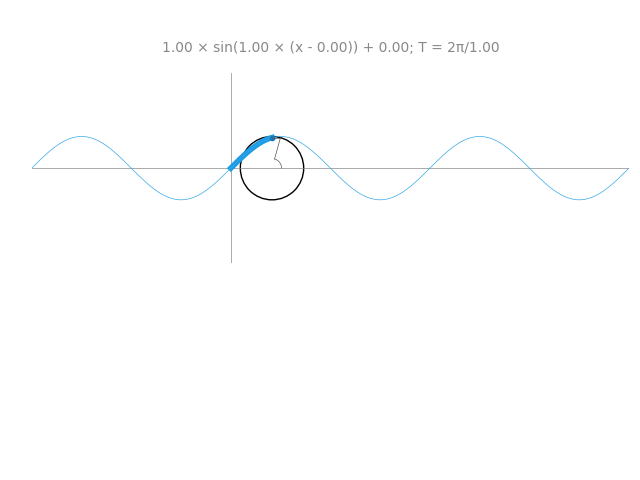

In [10]:
state = State()
state.define({
    StateProp.MODIFIED: False,
    StateProp.TRIG_FUNCTION: ToggleButtonOption.SINE,
    StateProp.PHASE_SHIFT: 0,
    StateProp.VERTICAL_SHIFT: 0,
    StateProp.HORIZONTAL_SCALAR: 1,
    StateProp.VERTICAL_SCALAR: 1,
})

ui = define_ui(state)

fig, animated_parts = itemgetter(
    PlotPart.FIG,
    PlotPart.ANIMATED_PARTS
)(define_plot(plt))

ani = animation.FuncAnimation(
    fig,
    animate(animated_parts, state),
    interval=ANIMATION_INTERVAL,
    frames=generate_frames(state),
    blit=True,
    cache_frame_data=False,
    repeat=False,
    save_count=ANIMATION_SAVE_COUNT,
)

display(ui)
ani.save(filename=f"./{NOTEBOOK_FILE_NAME}.gif", writer='pillow')
ani; # The ; semicolon suppresses a print out of the type of object.
